In [1]:
!pip install pyprob pymunk pygame 

Defaulting to user installation because normal site-packages is not writeable
  Using cached pymunk-5.6.0-py2.py3-none-manylinux1_x86_64.whl (535 kB)


In [2]:
import random
import pygame
import pygame.locals
import pymunk
import pymunk.pygame_util
import matplotlib.pyplot as plt
%matplotlib inline

import pyprob
from pyprob import Model
from pyprob.distributions import Uniform, Normal
pyprob.seed(1)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
Loading chipmunk for Linux (64bit) [/home/aziz/.local/lib/python3.8/site-packages/pymunk/libchipmunk.so]


In [3]:
def plot_dist(dist):
    dist = dist.resample(1000)
    dist_ball_radius = dist.map(lambda trace: trace.named_variables['ball_radius'].value)
    dist_ball_elasticity = dist.map(lambda trace: trace.named_variables['ball_elasticity'].value)
    dist_num_bumpers = dist.map(lambda trace: trace.named_variables['num_bumpers'].value)
    dist_balls_in_box = dist.map(lambda trace: trace.named_variables['balls_in_box'].value)
    def collect_xy(trace):
        num_bumpers = int(trace.named_variables['num_bumpers'].value)
        return [[int(trace.named_variables['bumper{}x'.format(i)].value), int(trace.named_variables['bumper{}y'.format(i)].value)] for i in range(num_bumpers)]
    dist_xy = dist.map(collect_xy)
    xys = []
    for xy in dist_xy.values:
#         print(xy)
        xys.extend(xy)
#     print(xys)
#     fig, ax = plt.subplots(3, 2, figsize=(10, 10))
    fig = plt.figure(figsize=(10,10))
    gs = fig.add_gridspec(3,2)
    
    ax = fig.add_subplot(gs[0,0])
    ax.scatter(*zip(*xys))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('bumpers')
    ax.set_xlim([-500, 1500])
    ax.set_ylim([-200, 600])
    
    ax = fig.add_subplot(gs[0,1])
    ax.hist(dist_num_bumpers.values_numpy())
    ax.set_title('num_bumpers')
    
    ax = fig.add_subplot(gs[1,0])
    ax.hist(dist_ball_radius.values_numpy())
    ax.set_title('ball_radius')
    
    ax = fig.add_subplot(gs[1,1])
    ax.hist(dist_ball_elasticity.values_numpy())
    ax.set_title('ball_elasticity')
    
#     ax = fig.add_subplot(gs[2,0])
#     ax[2, 0].remove()

    ax = fig.add_subplot(gs[2,0:])
    ax.hist(dist_balls_in_box.values_numpy())
    ax.set_title('balls_in_box')
    plt.tight_layout()
    
def run_trace(trace):
    num_bumpers = int(trace.named_variables['num_bumpers'].value)
    bumpers = [[int(trace.named_variables['bumper{}x'.format(i)].value), int(trace.named_variables['bumper{}y'.format(i)].value)] for i in range(num_bumpers)]
    ball_radius = max(5, int(trace.named_variables['ball_radius'].value))
    ball_elasticity = float(trace.named_variables['ball_elasticity'].value)
    p = PhysicsSim(bumpers=bumpers, ball_radius=ball_radius, ball_elasticity=ball_elasticity, physics_steps_per_frame=5, draw=True, print_acc=True)
    p.run()

# A Simple Physics Simulator

In [4]:
class PhysicsSim():
    def __init__(self, bumpers=[[10, 10]], bumper_size=100, balls_to_create=10, ball_radius=10, ball_elasticity=0.9, physics_steps_per_frame=5, draw=True, print_acc=False):
        self._space = pymunk.Space()
        self._space.gravity = (0.0, -900.0)
        self._dt = 0.01
        self._physics_steps_per_frame = physics_steps_per_frame
        pygame.init()
        self._screen = pygame.display.set_mode((1000, 600))
        self._clock = pygame.time.Clock()
        self._draw_options = pymunk.pygame_util.DrawOptions(self._screen)
        self._bumpers = bumpers
        self._bumper_size = bumper_size
        self._box_x = [850, 950]
        self._box_y = [50, 150]
        self._balls_to_create = balls_to_create
        self._ball_elasticity = ball_elasticity
        self._ball_radius = ball_radius
        self._balls = []
        self._balls_in_box = []
        self._ticks_to_next_ball = 1
        self._add_static_bodies()
        self._timeout = 500
        self._running = True
        self._draw = draw
        self._print_acc = print_acc

    def run(self):
        i = 0
        while self._running:
            i += 1
            if i > self._timeout:
                self._running = False
            for x in range(self._physics_steps_per_frame):
                self._space.step(self._dt)
                self._update()
            self._process_events()
            if self._draw:
                self._clear_screen()
                self._draw_objects()
                pygame.display.flip()
                pygame.display.set_caption('fps: {:.2f}, balls in box: {}'.format(self._clock.get_fps(), len(self._balls_in_box)))
                self._clock.tick(100) # delay between frames
        self._process_events()
        for j in range(100):
            i += 1
            if i > self._timeout:
                self._running = False
            for x in range(self._physics_steps_per_frame):
                self._space.step(self._dt)
                self._update()
            self._process_events()
            if self._draw:
                self._clear_screen()
                self._draw_objects()
                pygame.display.flip()
                pygame.display.set_caption('fps: {:.2f}, balls in box: {}'.format(self._clock.get_fps(), len(self._balls_in_box)))
                self._clock.tick(100) # delay between frames


    def _add_static_bodies(self):
        static_body = self._space.static_body
        static_lines = []
        static_lines.append(pymunk.Segment(static_body, (40, 520), (140, 420), 2))
        for bumper in self._bumpers:
            static_lines.append(pymunk.Segment(static_body, (bumper[0], bumper[1]), (bumper[0] + self._bumper_size, bumper[1]), 2))
#         static_lines.append(pymunk.Segment(static_body, (200, 200), (500, 200), 0))
        static_lines.append(pymunk.Segment(static_body, (self._box_x[0], self._box_y[0]), (self._box_x[1], self._box_y[0]), 2))
        static_lines.append(pymunk.Segment(static_body, (self._box_x[0], self._box_y[0]), (self._box_x[0], self._box_y[1]), 2))
        static_lines.append(pymunk.Segment(static_body, (self._box_x[1], self._box_y[0]), (self._box_x[1], self._box_y[1]), 2))

        #         static_lines.append(pymunk.Segment(static_body, (111, 280), (407,246), 0))
        for line in static_lines:
            line.elasticity = 0.95
            line.friction = 0.9
        self._space.add(static_lines)
        
    def _process_events(self):
        for event in pygame.event.get():
            if event.type == pygame.locals.QUIT:
                self._running = False
            elif event.type == pygame.locals.KEYDOWN and event.key == pygame.locals.K_ESCAPE:
                self._running = False
#             elif event.type == pygame.locals.KEYDOWN and event.key == pygame.locals.K_p:
#                 pygame.image.save(self._screen, 'game.png')

    def _update(self):
        if self._balls_to_create > 0:
            self._ticks_to_next_ball -= 1
            if self._ticks_to_next_ball <= 0:
                self._create_ball()
                self._ticks_to_next_ball = 60
                self._balls_to_create -= 1
        self._balls_in_box = [ball for ball in self._balls 
                              if ball.body.position.x > self._box_x[0] 
                              and ball.body.position.x < self._box_x[1] 
                              and ball.body.position.y > self._box_y[0] 
                              and ball.body.position.y < self._box_y[1]
                             ]
        if self._print_acc:           
            print(f"Number of balls in the box: {len(self._balls_in_box)}, Average number of balls in the box: {(len(self._balls_in_box)/10)*100}%", end="\r")
        balls_to_remove = [ball for ball in self._balls if ball.body.position.y < 50]
        for ball in balls_to_remove:
            self._space.remove(ball, ball.body)
            self._balls.remove(ball)
        if len(self._balls) == 0:
            self._running = False
        elif len(self._balls) == len(self._balls_in_box):
            self._running = False
            
    def _create_ball(self):
        mass = 10
        inertia = pymunk.moment_for_circle(mass, 0, self._ball_radius, (0, 0))
        body = pymunk.Body(mass, inertia)
        body.position = 50 + random.random()*0.1, 550
#         body.velocity = 0, 0
        shape = pymunk.Circle(body, self._ball_radius, (0, 0))
        shape.elasticity = self._ball_elasticity
        shape.friction = 0.9
        self._space.add(body, shape)
        self._balls.append(shape)

    def _clear_screen(self):
        self._screen.fill(pygame.color.THECOLORS['white'])
        
    def _draw_objects(self):
        self._space.debug_draw(self._draw_options)

In [5]:
p = PhysicsSim(bumpers=[[250,100], [590,150]], ball_elasticity=0.85, physics_steps_per_frame=3, draw=True, print_acc=True)
p.run()
# p._balls_in_box


In [6]:
class PhysicsModel(Model):
    def __init__(self, draw=True, physics_steps_per_frame=5):
        super().__init__('Physics')
        self._draw = draw
        self._physics_steps_per_frame = physics_steps_per_frame
        
    def forward(self):
        ball_radius = max(5,int(pyprob.sample(Normal(12, 6), name='ball_radius')))
        ball_elasticity = float(pyprob.sample(Normal(0.9, 0.1), name='ball_elasticity'))
        num_bumpers = int(pyprob.sample(Uniform(1, 50), name='num_bumpers'))
        bumpers = []
        for i in range(num_bumpers):
            x = int(pyprob.sample(Normal(450, 250), name='bumper{}x'.format(i)))
            y = int(pyprob.sample(Normal(200, 100), name='bumper{}y'.format(i)))
            bumpers.append([x, y])
        p = PhysicsSim(bumpers=bumpers, ball_radius=ball_radius, ball_elasticity=ball_elasticity, draw=self._draw, physics_steps_per_frame=self._physics_steps_per_frame)
        p.run()
        balls_in_box = len(p._balls_in_box)
        
        pyprob.observe(Normal(balls_in_box, 1), balls_in_box, name='balls_in_box')

In [19]:
model = PhysicsModel(draw=True, physics_steps_per_frame=2)
trace = model.get_trace()

# Prior distribution¶


In [7]:
model = PhysicsModel(draw=False)
prior = model.prior(num_traces=500)

Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:13 | 0d:00:00:00 | #################### | 500/500 | 36.55       


Resample, num_samples: 1000, min_index: 0, max_index: 500, ess_before_resample: 499.9999999999998
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 1000/1000 | 133,146.17       
Map, min_index: 0, max_index: 1000
Time spent  | Time remain.| Progress             | Values    | Values/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 1000/1000 | 75,591.41       
Map, min_index: 0, max_index: 1000
Time spent  | Time remain.| Progress             | Values    | Values/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 1000/1000 | 144,337.81       
Map, min_index: 0, max_index: 1000
Time spent  | Time remain.| Progress             | Values    | Values/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 1000/1000 | 162,392.60       
Map, min_index: 0, max_index: 1000
Time spent  | Time remain.| Progress             | Values    | Values/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 1000/1000 | 263,0

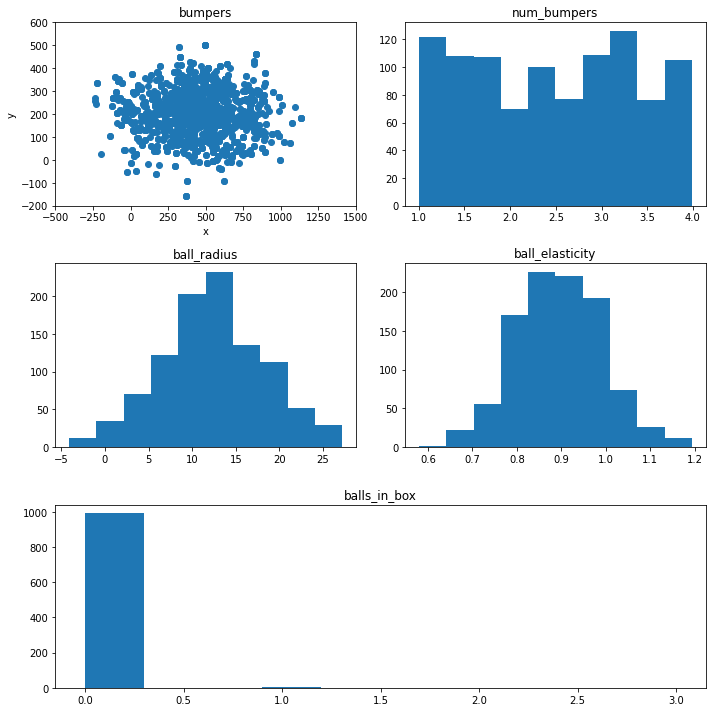

In [57]:
plot_dist(prior)


# Some samples from the prior

In [58]:
run_trace(prior.sample())


# Posterior distribution

In [8]:
pyprob.seed(1)
model = PhysicsModel(draw=False)
posterior_rmh = model.posterior(num_traces=2000, observe={'balls_in_box': 10}, inference_engine=pyprob.InferenceEngine.RANDOM_WALK_METROPOLIS_HASTINGS)

Time spent  | Time remain.| Progress             | Trace     | Accepted|Smp reuse| Traces/sec
0d:00:01:15 | 0d:00:00:00 | #################### | 2000/2000 |  57.30% |  95.04% | 26.43       


Resample, num_samples: 1000, min_index: 0, max_index: 2000, ess_before_resample: 2000.0000000000039
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 1000/1000 | 156,982.55       
Map, min_index: 0, max_index: 1000
Time spent  | Time remain.| Progress             | Values    | Values/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 1000/1000 | 204,535.41       
Map, min_index: 0, max_index: 1000
Time spent  | Time remain.| Progress             | Values    | Values/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 1000/1000 | 219,116.87       
Map, min_index: 0, max_index: 1000
Time spent  | Time remain.| Progress             | Values    | Values/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 1000/1000 | 301,833.09       
Map, min_index: 0, max_index: 1000
Time spent  | Time remain.| Progress             | Values    | Values/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 1000/1000 | 23

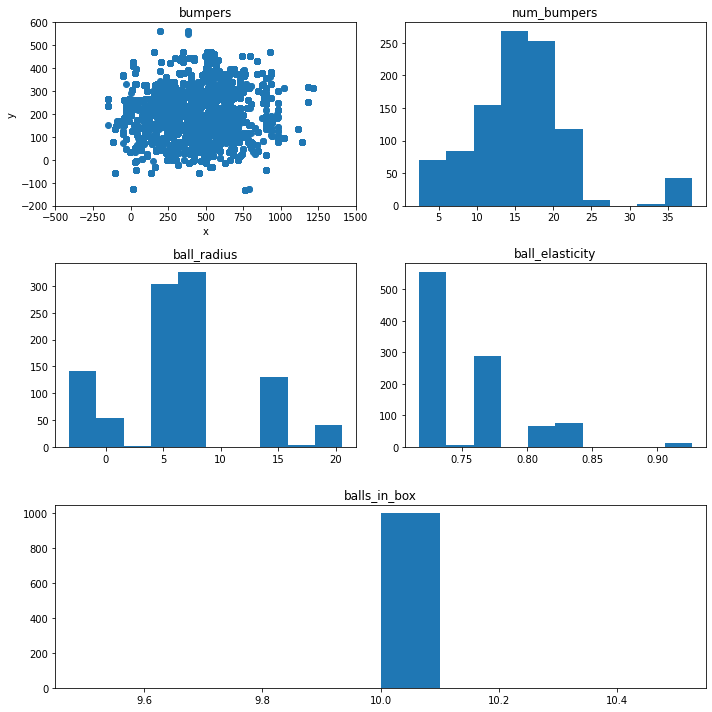

In [9]:
plot_dist(posterior_rmh)


## Some samples from the posterior¶


In [10]:
for _ in range(100):
    run_trace(posterior_rmh.sample())


# Another posterior

In [22]:
model = PhysicsModel(draw=False)
posterior_rmh_5 = model.posterior(num_traces=500, observe={'balls_in_box': 5}, inference_engine=pyprob.InferenceEngine.RANDOM_WALK_METROPOLIS_HASTINGS)

Time spent  | Time remain.| Progress             | Trace   | Accepted|Smp reuse| Traces/sec
0d:00:00:04 | 0d:00:00:00 | #################### | 500/500 |  86.00% |  80.00% | 119.38       


Resample, num_samples: 1000, min_index: 0, max_index: 500, ess_before_resample: 499.9999999999998
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 1000/1000 | 285,204.69       
Map, min_index: 0, max_index: 1000
Time spent  | Time remain.| Progress             | Values    | Values/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 1000/1000 | 335,879.86       
Map, min_index: 0, max_index: 1000
Time spent  | Time remain.| Progress             | Values    | Values/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 1000/1000 | 126,088.60       
Map, min_index: 0, max_index: 1000
Time spent  | Time remain.| Progress             | Values    | Values/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 1000/1000 | 152,014.86       
Map, min_index: 0, max_index: 1000
Time spent  | Time remain.| Progress             | Values    | Values/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 1000/1000 | 155,

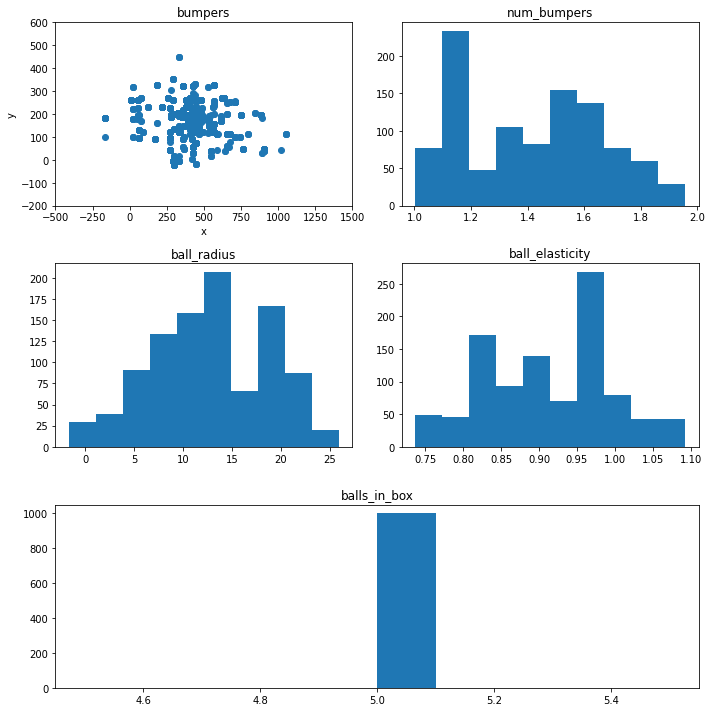

In [23]:
plot_dist(posterior_rmh_5)


In [28]:
run_trace(posterior_rmh_5.sample())
